In [23]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class RandomMotionDataset(Dataset):
    def __init__(self, data_df, gt_df, start_idx=0, end_idx=None, samples_per_epoch=1000, clip_depth=500):
        """
        start_idx: Starting frame index for this split.
        end_idx: Ending frame index for this split.
        """
        self.data = data_df.values.reshape(-1, 32, 32).astype(np.float32)
        # Add check for NaNs/Infs in the input data
        if not np.all(np.isfinite(self.data)):
            raise ValueError("Input data (hard_data_clean_70_150) contains non-finite values (NaN/Inf). Please clean your data.")

        self.gt = gt_df
        # Add check for NaNs/Infs in critical ground truth columns
        if not np.all(np.isfinite(self.gt[['click_center_row', 'click_center_col']].values)):
            raise ValueError("Ground truth data (hard_move) contains non-finite values (NaN/Inf) in 'click_center_row' or 'click_center_col'. Please clean your data.")

        self.clip_depth = clip_depth
        self.length = samples_per_epoch

        # Define the valid range for sampling start points
        if end_idx is None:
            end_idx = len(self.data)

        self.min_idx = start_idx
        self.max_idx = end_idx - clip_depth

        if self.max_idx <= self.min_idx:
            raise ValueError(f"Invalid Index Range: {start_idx} to {end_idx} with depth {clip_depth}")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 1. Randomly select a start point within the assigned range
        start_t = np.random.randint(self.min_idx, self.max_idx)
        end_t = start_t + self.clip_depth

        # 2. Grab the 3D Cube (1, Depth, 32, 32)
        clip = self.data[start_t : end_t]
        x = torch.tensor(clip).unsqueeze(0)

        # 3. Calculate the Motion Vector (End Pos - Start Pos)
        row_start = self.gt.iloc[start_t]['click_center_row']
        col_start = self.gt.iloc[start_t]['click_center_col']

        row_end = self.gt.iloc[end_t]['click_center_row']
        col_end = self.gt.iloc[end_t]['click_center_col']

        delta_row = round(row_end - row_start)
        delta_col = round(col_end - col_start)
        y = torch.tensor([delta_row, delta_col], dtype=torch.float32)

        # Optionally add a check here as well, though init checks should catch most issues
        if not torch.isfinite(y).all():
             raise ValueError(f"Generated target `y` contains non-finite values at start_t={start_t}, end_t={end_t}.")

        return x, y

In [24]:
import torch.nn as nn

class MotionRegressor(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            # Layer 1: Aggressive temporal stride (5) to reduce 500 -> 100
            # Input: (Batch, 1, 500, 32, 32)
            nn.Conv3d(1, 16, kernel_size=(5, 3, 3), stride=(5, 1, 1), padding=(2, 1, 1)),
            nn.BatchNorm3d(16),
            nn.ReLU(),

            # Layer 2: Pool to reduce 100 -> 50, spatial 32 -> 16
            nn.MaxPool3d(kernel_size=(2, 2, 2)),

            # Layer 3: Standard Conv
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),

            # Layer 4: Pool to reduce 50 -> 25, spatial 16 -> 8
            nn.MaxPool3d(kernel_size=(2, 2, 2)),

            # Layer 5: Final Conv features
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1)) # Global Average Pooling -> (Batch, 64, 1, 1, 1)
        )

        # Regressor Head: Predicts 2 values (Delta Row, Delta Col)
        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def forward(self, x):
        feat = self.features(x)
        return self.regressor(feat)

In [5]:
from google.colab import drive
import pandas as pd

# 1. Connect to Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [25]:
import pandas as pd
import os

# Correct path located by search
base_path = '/content/drive/My Drive/hackathon/data/super_easy'

print(f"Loading data from: {base_path}")

if os.path.exists(base_path):
    # Load the parquet files into the variables expected by the training cell
    hard_data_clean_70_150 = pd.read_parquet(f'{base_path}/track2_data.parquet')
    hard_move = pd.read_parquet(f'{base_path}/ground_truth.parquet')

    print("Files loaded successfully.")
    print(f"Input Data shape: {hard_data_clean_70_150.shape}")
    print(f"Ground Truth shape: {hard_move.shape}")
else:
    print(f"Path not found: {base_path}. Please check your Drive mounting.")

Loading data from: /content/drive/My Drive/hackathon/data/super_easy
Files loaded successfully.
Input Data shape: (150000, 1024)
Ground Truth shape: (150000, 15)


In [28]:
# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- 1. Define Splits Based on Time ---
fs = 500
train_limit = 200 * fs       # 0 to 130s
valid_limit = (200 + 20) * fs # 130s to 150s
# Test is 150s to End

print(f"Train Split: 0 - {train_limit} frames")
print(f"Valid Split: {train_limit} - {valid_limit} frames")
print(f"Test Split:  {valid_limit} - End")

# --- 2. Create Datasets & Loaders ---
# Train Dataset
train_ds = RandomMotionDataset(
    hard_data_clean_70_150, hard_move,
    start_idx=0, end_idx=train_limit,
    samples_per_epoch=1000
)
train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)

# Validation Dataset
val_ds = RandomMotionDataset(
    hard_data_clean_70_150, hard_move,
    start_idx=train_limit, end_idx=valid_limit,
    samples_per_epoch=200 # Smaller sample for validation
)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

# --- 3. Model Setup ---
model = MotionRegressor().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

# --- 4. Training Loop with Early Stopping ---
best_val_loss = float('inf')
patience = 100
trigger_times = 0

for epoch in range(1000): # Max epochs
    # -- TRAIN --
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)

    # -- VALIDATE --
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val, y_val = X_val.to(device), y_val.to(device)
            preds = model(X_val)
            loss = criterion(preds, y_val)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -- EARLY STOPPING --
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        print(f"  -> No improvement. Patience: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"  -> Early stopping triggered! Best Val Loss: {best_val_loss:.4f}")
            # Load best weights
            model.load_state_dict(torch.load('best_model.pth'))
            break

Using device: cuda
Train Split: 0 - 100000 frames
Valid Split: 100000 - 110000 frames
Test Split:  110000 - End
Epoch 1 | Train Loss: 5.0965 | Val Loss: 5.3421
Epoch 2 | Train Loss: 5.0191 | Val Loss: 5.0023
Epoch 3 | Train Loss: 5.0071 | Val Loss: 4.6206
Epoch 4 | Train Loss: 4.6983 | Val Loss: 5.4996
  -> No improvement. Patience: 1/100
Epoch 5 | Train Loss: 4.8250 | Val Loss: 5.1776
  -> No improvement. Patience: 2/100
Epoch 6 | Train Loss: 5.1081 | Val Loss: 5.0842
  -> No improvement. Patience: 3/100
Epoch 7 | Train Loss: 4.8986 | Val Loss: 5.1899
  -> No improvement. Patience: 4/100
Epoch 8 | Train Loss: 5.1419 | Val Loss: 5.1699
  -> No improvement. Patience: 5/100
Epoch 9 | Train Loss: 4.9971 | Val Loss: 5.0055
  -> No improvement. Patience: 6/100
Epoch 10 | Train Loss: 4.8976 | Val Loss: 5.0986
  -> No improvement. Patience: 7/100
Epoch 11 | Train Loss: 5.0819 | Val Loss: 5.1570
  -> No improvement. Patience: 8/100
Epoch 12 | Train Loss: 4.9563 | Val Loss: 5.5165
  -> No impro

In [29]:
# Test on a single sample from the validation set
with torch.no_grad():
    sample_x, sample_y = val_ds[0]
    # Move input to device, then move output back to cpu for printing
    pred = model(sample_x.unsqueeze(0).to(device))
    print(f"True Delta: {sample_y.numpy()} | Predicted: {pred[0].cpu().numpy()}")

True Delta: [ 2. -2.] | Predicted: [ 1.453965  -1.8526086]


In [9]:
import os

# Create a directory for models if it doesn't exist
# This ensures the model is saved to Google Drive and persists after the runtime disconnects
save_dir = os.path.join(base_path, 'models')
os.makedirs(save_dir, exist_ok=True)

# Define the file path
save_path = os.path.join(save_dir, 'motion_regressor_v1.pth')

# Save the model weights
torch.save(model.state_dict(), save_path)

print(f"Model weights saved to: {save_path}")

Model weights saved to: /content/drive/My Drive/hackathon/data/super_easy/models/motion_regressor_v1.pth


In [35]:
import matplotlib.pyplot as plt

class EvaluationDataset(Dataset):
    def __init__(self, data_df, gt_df, start_idx, end_idx, clip_depth=500, stride=100):
        """
        Iterates deterministically from start_idx to end_idx with a given stride.
        """
        self.data = data_df.values.reshape(-1, 32, 32).astype(np.float32)
        self.gt = gt_df
        self.clip_depth = clip_depth
        self.indices = list(range(start_idx, end_idx - clip_depth, stride))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_t = self.indices[idx]
        end_t = start_t + self.clip_depth

        # Input
        clip = self.data[start_t : end_t]
        x = torch.tensor(clip).unsqueeze(0)

        # Ground Truth
        row_start = self.gt.iloc[start_t]['click_center_row']
        col_start = self.gt.iloc[start_t]['click_center_col']
        row_end = self.gt.iloc[end_t]['click_center_row']
        col_end = self.gt.iloc[end_t]['click_center_col']

        delta_row = round(row_end - row_start)
        delta_col = round(col_end - col_start)
        y = torch.tensor([delta_row, delta_col], dtype=torch.float32)

        return x, y

# Create evaluation dataset (Test set: 30,000 to End)
# Using a stride of 100 to get a dense set of points without checking every single frame
test_dataset = EvaluationDataset(
    hard_data_clean_70_150,
    hard_move,
    start_idx=30000,
    end_idx=len(hard_data_clean_70_150),
    stride=200
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [36]:
X_batch.shape

torch.Size([15, 1, 500, 32, 32])

Running evaluation on test data...


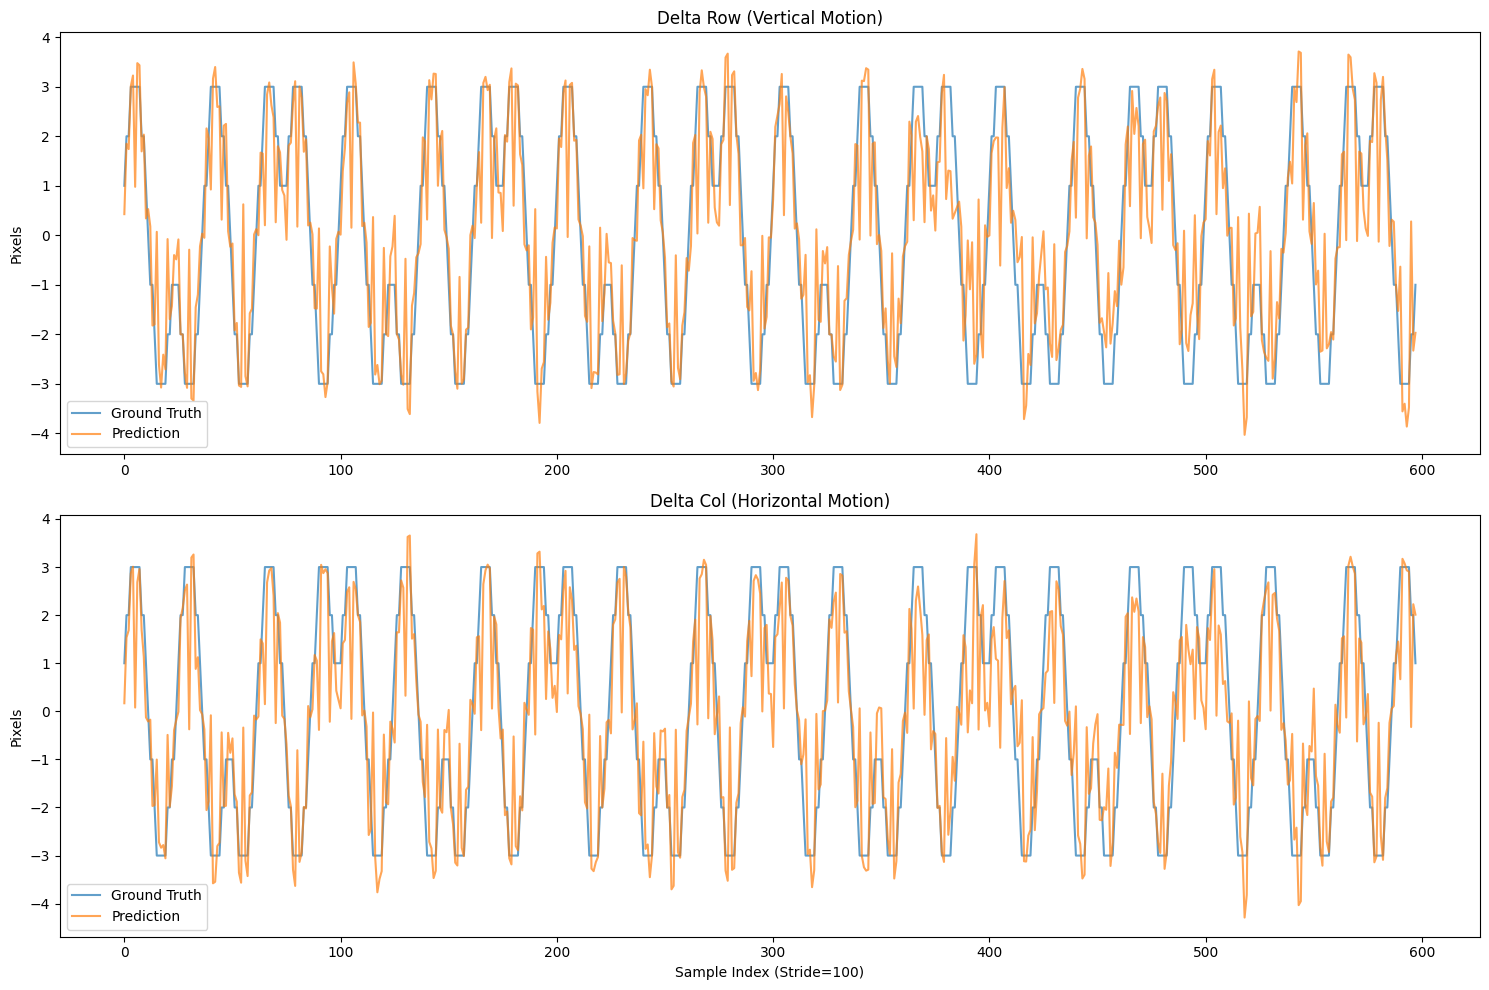

In [37]:
model.eval()
all_preds = []
all_targets = []

print("Running evaluation on test data...")
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)

        all_preds.append(outputs.cpu().numpy())
        all_targets.append(y_batch.numpy())

# Concatenate results
all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Row Delta
axes[0].plot(all_targets[:, 0], label='Ground Truth', alpha=0.7)
axes[0].plot(all_preds[:, 0], label='Prediction', alpha=0.7)
axes[0].set_title('Delta Row (Vertical Motion)')
axes[0].set_ylabel('Pixels')
axes[0].legend()

# Col Delta
axes[1].plot(all_targets[:, 1], label='Ground Truth', alpha=0.7)
axes[1].plot(all_preds[:, 1], label='Prediction', alpha=0.7)
axes[1].set_title('Delta Col (Horizontal Motion)')
axes[1].set_ylabel('Pixels')
axes[1].set_xlabel('Sample Index (Stride=100)')
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define new splits for FusionNet training and evaluation
# Using fs = 500 frames per second

fusion_train_limit = 120 * fs       # 0 to 120s (60,000 frames)
fusion_valid_limit = (120 + 25) * fs # 120s to 145s (72,500 frames)

print(f"FusionNet Train Split: 0 - {fusion_train_limit} frames")
print(f"FusionNet Valid Split: {fusion_train_limit} - {fusion_valid_limit} frames")
print(f"FusionNet Test Split:  {fusion_valid_limit} - End")

FusionNet Train Split: 0 - 60000 frames
FusionNet Valid Split: 60000 - 72500 frames
FusionNet Test Split:  72500 - End


In [ ]:
class DualInputEvaluationDataset(Dataset):
    def __init__(self, data_df, gt_df, start_idx, end_idx, clip_depth=500, stride=100):
        self.data = data_df.values.reshape(-1, 32, 32).astype(np.float32)
        # Add check for NaNs/Infs in the input data
        if not np.all(np.isfinite(self.data)):
            raise ValueError("Input data (hard_data_clean_70_150) contains non-finite values (NaN/Inf). Please clean your data.")

        self.gt = gt_df
        # Add check for NaNs/Infs in critical ground truth columns
        if not np.all(np.isfinite(self.gt[['click_center_row', 'click_center_col', 'vx', 'vy']].values)):
            raise ValueError("Ground truth data (hard_move) contains non-finite values (NaN/Inf) in 'click_center_row', 'click_center_col', 'vx', or 'vy'. Please clean your data.")

        self.clip_depth = clip_depth
        self.indices = list(range(start_idx, end_idx - clip_depth, stride))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_t = self.indices[idx]
        end_t = start_t + self.clip_depth

        clip = self.data[start_t : end_t]
        x_neural = torch.tensor(clip).unsqueeze(0)

        vx = self.gt.iloc[start_t : end_t]['vx'].values
        vy = self.gt.iloc[start_t : end_t]['vy'].values
        x_velocity = np.stack([vx, vy], axis=0).astype(np.float32)
        x_velocity = torch.tensor(x_velocity)

        # Check for non-finite values in x_velocity before returning
        if not torch.isfinite(x_velocity).all():
            raise ValueError(f"Generated x_velocity contains non-finite values at start_t={start_t}, end_t={end_t}.")

        row_start = self.gt.iloc[start_t]['click_center_row']
        col_start = self.gt.iloc[start_t]['click_center_col']
        row_end = self.gt.iloc[end_t]['click_center_row']
        col_end = self.gt.iloc[end_t]['click_center_col']

        y = torch.tensor([round(row_end - row_start), round(col_end - col_start)], dtype=torch.float32)

        # Check for non-finite values in y before returning
        if not torch.isfinite(y).all():
            raise ValueError(f"Generated target `y` contains non-finite values at start_t={start_t}, end_t={end_t}.")

        return x_neural, x_velocity, y

# Evaluation on Test Split (Using newly defined fusion_valid_limit to End)
test_dataset_fusion = DualInputEvaluationDataset(
    hard_data_clean_70_150, hard_move,
    start_idx=fusion_valid_limit,
    end_idx=len(hard_data_clean_70_150),
    stride=100
)
test_loader_fusion = DataLoader(test_dataset_fusion, batch_size=32, shuffle=False)

In [ ]:
# --- Train FusionNet with Splits & Early Stopping ---

# 1. Dataset & Loader (Using newly defined fusion_train_limit / fusion_valid_limit)
# Using DualInputDataset for training (supports random sampling per epoch)
train_ds_dual = DualInputDataset(hard_data_clean_70_150, hard_move, start_idx=0, end_idx=fusion_train_limit, samples_per_epoch=500)
val_ds_dual = DualInputDataset(hard_data_clean_70_150, hard_move, start_idx=fusion_train_limit, end_idx=fusion_valid_limit, samples_per_epoch=200)

train_loader_dual = DataLoader(train_ds_dual, batch_size=16, shuffle=True)
val_loader_dual = DataLoader(val_ds_dual, batch_size=16, shuffle=False)

# 2. Model
fusion_model = FusionNet().to(device)
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 3. Training Loop
best_val_loss = float('inf')
patience = 5
trigger_times = 0

print("Starting FusionNet Training...")
for epoch in range(100):
    # -- TRAIN --
    fusion_model.train()
    train_loss = 0
    for x_n, x_v, y in train_loader_dual:
        x_n, x_v, y = x_n.to(device), x_v.to(device), y.to(device)
        optimizer.zero_grad()
        preds = fusion_model(x_n, x_v)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_dual)

    # -- VALIDATE --
    fusion_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_n, x_v, y in val_loader_dual:
            x_n, x_v, y = x_n.to(device), x_v.to(device), y.to(device)
            preds = fusion_model(x_n, x_v)
            val_loss += criterion(preds, y).item()

    avg_val_loss = val_loss / len(val_loader_dual)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -- EARLY STOPPING --
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(fusion_model.state_dict(), 'best_fusion_model.pth')
    else:
        trigger_times += 1
        print(f"  -> Patience: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"  -> Early Stopping! Best Val Loss: {best_val_loss:.4f}")
            fusion_model.load_state_dict(torch.load('best_fusion_model.pth'))
            break

TypeError: DualInputEvaluationDataset.__init__() got an unexpected keyword argument 'samples_per_epoch'

### v2 add cursor info

Running on device: cuda
Initializing Datasets...

--- Starting Training ---
Epoch 01 | Train Loss: 0.02384 | Val Loss: 0.01443
Epoch 02 | Train Loss: 0.00674 | Val Loss: 0.00345
Epoch 03 | Train Loss: 0.00554 | Val Loss: 0.00273
Epoch 04 | Train Loss: 0.00595 | Val Loss: 0.00531
Epoch 05 | Train Loss: 0.00543 | Val Loss: 0.00345
Epoch 06 | Train Loss: 0.00523 | Val Loss: 0.00254
Epoch 07 | Train Loss: 0.00496 | Val Loss: 0.00562
Epoch 08 | Train Loss: 0.00433 | Val Loss: 0.00730
Epoch 09 | Train Loss: 0.00390 | Val Loss: 0.01002
Epoch 10 | Train Loss: 0.00399 | Val Loss: 0.00891
Epoch 11 | Train Loss: 0.00373 | Val Loss: 0.01725
Early stopping triggered! Best Val Loss: 0.00254

--- Starting Evaluation on Test Set ---


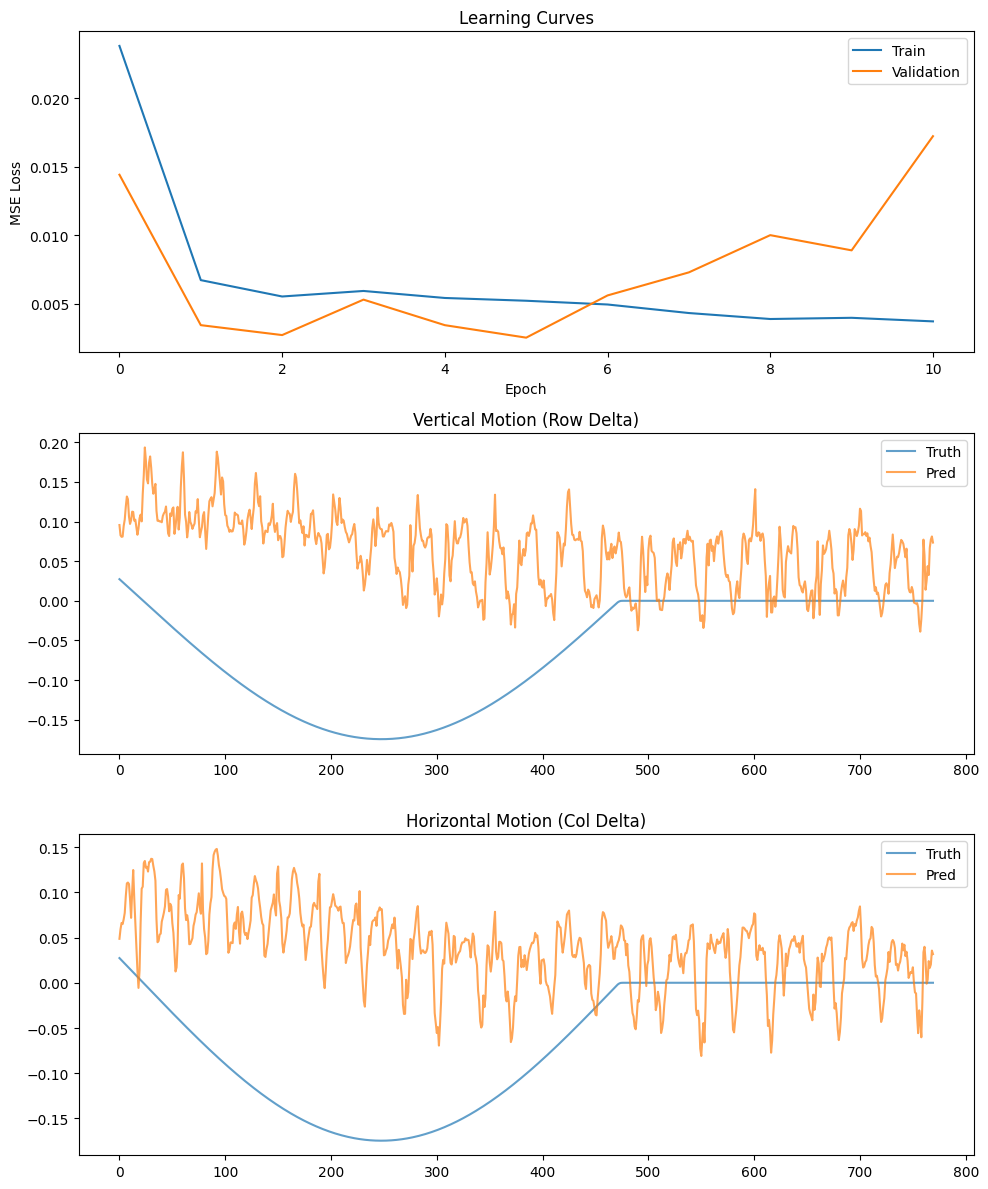

In [ ]:
# Consolidated FusionNet Pipeline: Train -> Valid -> Test -> Plot

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# --- 1. Class Definitions ---

class DualInputDataset(Dataset):
    def __init__(self, data_df, gt_df, start_idx=0, end_idx=None, samples_per_epoch=1000, clip_depth=500):
        self.data = data_df.values.reshape(-1, 32, 32).astype(np.float32)
        if not np.all(np.isfinite(self.data)):
            raise ValueError("Input data contains non-finite values.")

        self.gt = gt_df
        if not np.all(np.isfinite(self.gt[['click_center_row', 'click_center_col', 'vx', 'vy']].values)):
            raise ValueError("Ground truth data contains non-finite values.")

        self.clip_depth = clip_depth
        self.length = samples_per_epoch

        if end_idx is None:
            end_idx = len(self.data)

        self.min_idx = start_idx
        self.max_idx = end_idx - clip_depth

        if self.max_idx <= self.min_idx:
            raise ValueError(f"Invalid Index Range: {start_idx} to {end_idx}")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start_t = np.random.randint(self.min_idx, self.max_idx)
        end_t = start_t + self.clip_depth

        clip = self.data[start_t : end_t]
        x_neural = torch.tensor(clip).unsqueeze(0)

        vx = self.gt.iloc[start_t : end_t]['vx'].values
        vy = self.gt.iloc[start_t : end_t]['vy'].values
        x_velocity = np.stack([vx, vy], axis=0).astype(np.float32)
        x_velocity = torch.tensor(x_velocity)

        if not torch.isfinite(x_velocity).all():
             raise ValueError(f"Generated x_velocity contains non-finite values at start_t={start_t}.")

        row_start = self.gt.iloc[start_t]['click_center_row']
        col_start = self.gt.iloc[start_t]['click_center_col']
        row_end = self.gt.iloc[end_t]['click_center_row']
        col_end = self.gt.iloc[end_t]['click_center_col']

        y = torch.tensor([row_end - row_start, col_end - col_start], dtype=torch.float32)

        if not torch.isfinite(y).all():
             raise ValueError(f"Generated target `y` contains non-finite values at start_t={start_t}.")

        return x_neural, x_velocity, y

class DualInputEvaluationDataset(Dataset):
    def __init__(self, data_df, gt_df, start_idx, end_idx, clip_depth=500, stride=100):
        self.data = data_df.values.reshape(-1, 32, 32).astype(np.float32)
        if not np.all(np.isfinite(self.data)):
            raise ValueError("Input data contains non-finite values.")
        self.gt = gt_df
        if not np.all(np.isfinite(self.gt[['click_center_row', 'click_center_col', 'vx', 'vy']].values)):
            raise ValueError("Ground truth data contains non-finite values.")
        self.clip_depth = clip_depth
        self.indices = list(range(start_idx, end_idx - clip_depth, stride))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_t = self.indices[idx]
        end_t = start_t + self.clip_depth

        clip = self.data[start_t : end_t]
        x_neural = torch.tensor(clip).unsqueeze(0)

        vx = self.gt.iloc[start_t : end_t]['vx'].values
        vy = self.gt.iloc[start_t : end_t]['vy'].values
        x_velocity = np.stack([vx, vy], axis=0).astype(np.float32)
        x_velocity = torch.tensor(x_velocity)

        if not torch.isfinite(x_velocity).all():
             raise ValueError(f"Generated x_velocity contains non-finite values at start_t={start_t}.")

        row_start = self.gt.iloc[start_t]['click_center_row']
        col_start = self.gt.iloc[start_t]['click_center_col']
        row_end = self.gt.iloc[end_t]['click_center_row']
        col_end = self.gt.iloc[end_t]['click_center_col']

        y = torch.tensor([row_end - row_start, col_end - col_start], dtype=torch.float32)

        if not torch.isfinite(y).all():
             raise ValueError(f"Generated target `y` contains non-finite values at start_t={start_t}.")

        return x_neural, x_velocity, y

class FusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.neural_branch = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(5, 3, 3), stride=(5, 1, 1), padding=(2, 1, 1)),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))
        )

        self.velocity_branch = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size=5, stride=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        self.regressor = nn.Sequential(
            nn.Linear(32 + 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x_neural, x_velocity):
        feat_n = self.neural_branch(x_neural).view(x_neural.size(0), -1)
        feat_v = self.velocity_branch(x_velocity).view(x_velocity.size(0), -1)
        combined = torch.cat((feat_n, feat_v), dim=1)
        return self.regressor(combined)

# --- 2. Setup & Execution ---

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Running on device: {device}")

fs = 500
fusion_train_limit = 120 * fs       # 0 - 120s
fusion_valid_limit = (120 + 25) * fs # 120s - 145s

print("Initializing Datasets...")
# Ensure 'hard_data_clean_70_150' and 'hard_move' are loaded in memory before running this
train_ds = DualInputDataset(hard_data_clean_70_150, hard_move, start_idx=0, end_idx=fusion_train_limit, samples_per_epoch=500)
val_ds = DualInputDataset(hard_data_clean_70_150, hard_move, start_idx=fusion_train_limit, end_idx=fusion_valid_limit, samples_per_epoch=200)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)

model = FusionNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_val_loss = float('inf')
patience = 5
trigger_times = 0
max_epochs = 30

print("\n--- Starting Training ---")
train_losses = []
val_losses = []

for epoch in range(max_epochs):
    model.train()
    batch_losses = []
    for x_n, x_v, y in train_loader:
        x_n, x_v, y = x_n.to(device), x_v.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model(x_n, x_v)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())
    epoch_train_loss = np.mean(batch_losses)
    train_losses.append(epoch_train_loss)

    model.eval()
    val_batch_losses = []
    with torch.no_grad():
        for x_n, x_v, y in val_loader:
            x_n, x_v, y = x_n.to(device), x_v.to(device), y.to(device)
            pred = model(x_n, x_v)
            v_loss = criterion(pred, y).item()
            val_batch_losses.append(v_loss)
    epoch_val_loss = np.mean(val_batch_losses)
    val_losses.append(epoch_val_loss)

    print(f"Epoch {epoch+1:02d} | Train Loss: {epoch_train_loss:.5f} | Val Loss: {epoch_val_loss:.5f}")

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_fusion_model_pipeline.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered! Best Val Loss: {best_val_loss:.5f}")
            break

# Evaluation
model.load_state_dict(torch.load('best_fusion_model_pipeline.pth'))
model.eval()
print("\n--- Starting Evaluation on Test Set ---")

test_ds = DualInputEvaluationDataset(
    hard_data_clean_70_150, hard_move,
    start_idx=fusion_valid_limit,
    end_idx=len(hard_data_clean_70_150),
    stride=100
)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

all_preds = []
all_targets = []

with torch.no_grad():
    for x_n, x_v, y in test_loader:
        x_n, x_v = x_n.to(device), x_v.to(device)
        outputs = model(x_n, x_v)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(y.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

fig, axes = plt.subplots(3, 1, figsize=(10, 12))
axes[0].plot(train_losses, label='Train')
axes[0].plot(val_losses, label='Validation')
axes[0].set_title('Learning Curves')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()

axes[1].plot(all_targets[:, 0], label='Truth', alpha=0.7)
axes[1].plot(all_preds[:, 0], label='Pred', alpha=0.7)
axes[1].set_title('Vertical Motion (Row Delta)')
axes[1].legend()

axes[2].plot(all_targets[:, 1], label='Truth', alpha=0.7)
axes[2].plot(all_preds[:, 1], label='Pred', alpha=0.7)
axes[2].set_title('Horizontal Motion (Col Delta)')
axes[2].legend()

plt.tight_layout()
plt.show()

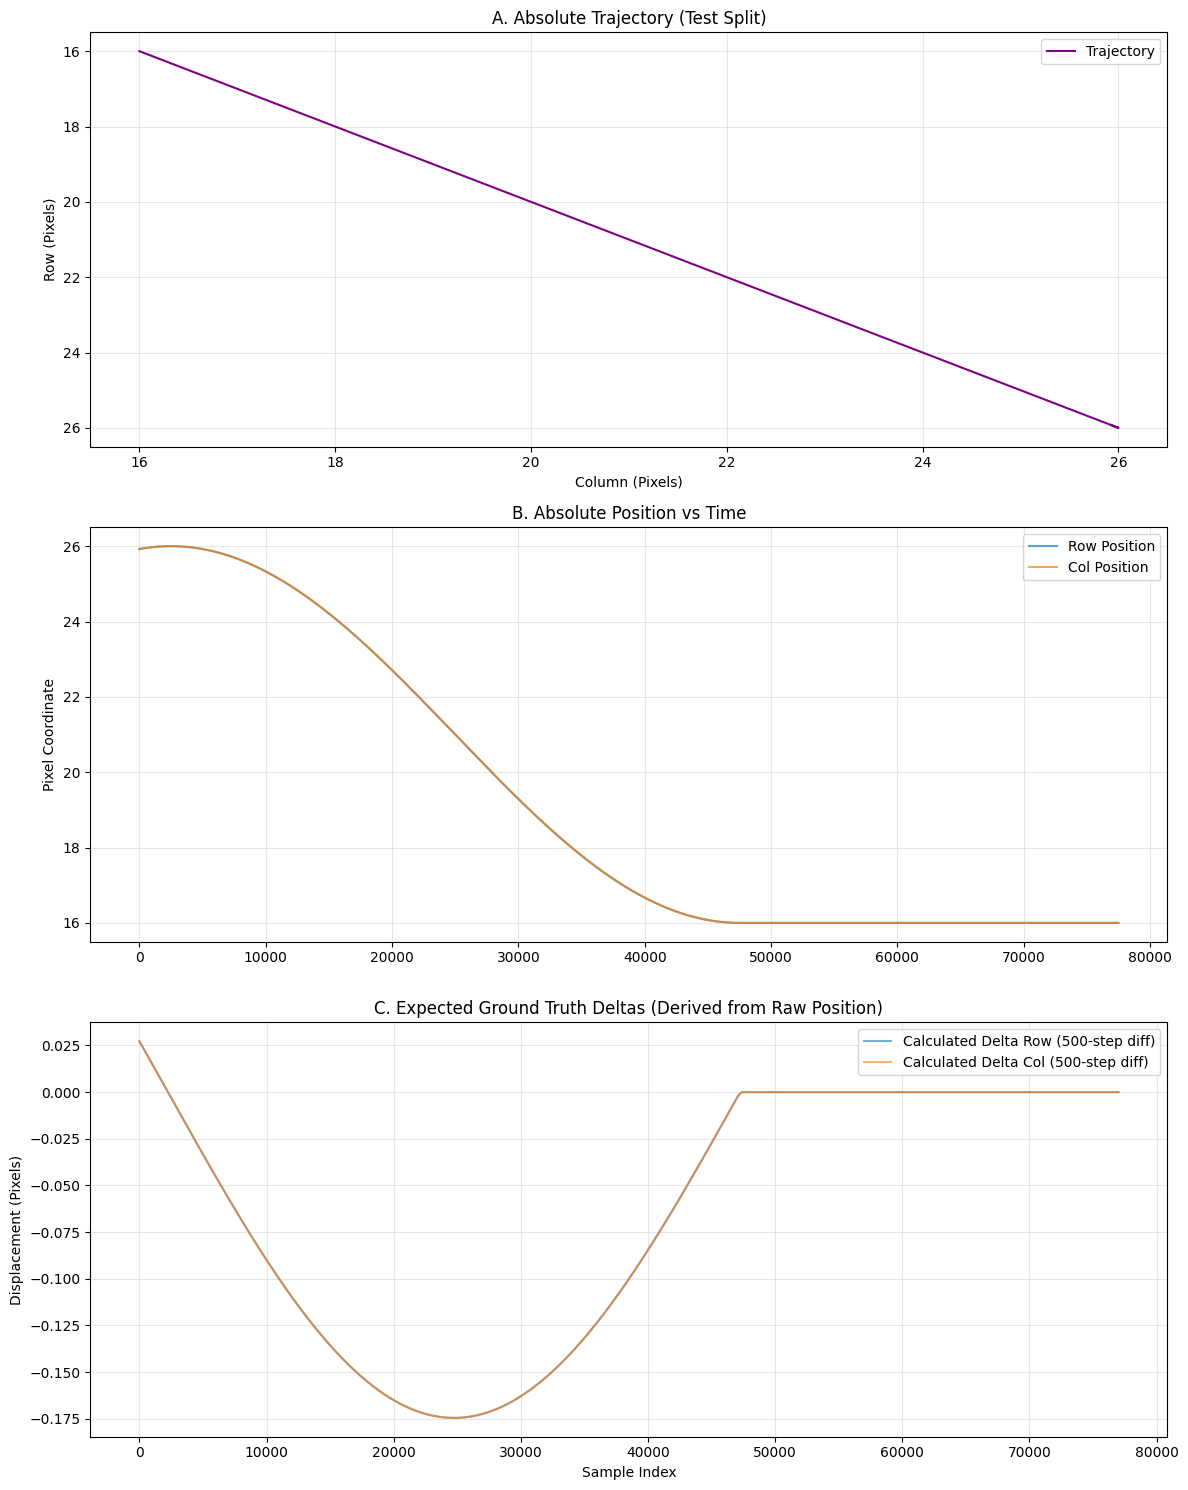

In [ ]:
# Cell to verify Ground Truth Data
import matplotlib.pyplot as plt

# 1. Get the raw absolute positions from the dataframe for the test split
# We use the same indices as the test dataset: fusion_valid_limit to End
start_index = fusion_valid_limit
end_index = len(hard_move)
test_data_slice = hard_move.iloc[start_index:end_index]

# 2. Extract specific columns
raw_rows = test_data_slice['click_center_row'].values
raw_cols = test_data_slice['click_center_col'].values

# 3. Plot
fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Plot A: Absolute Trajectory (The actual path)
axes[0].plot(raw_cols, raw_rows, label='Trajectory', color='purple')
axes[0].set_title('A. Absolute Trajectory (Test Split)')
axes[0].set_xlabel('Column (Pixels)')
axes[0].set_ylabel('Row (Pixels)')
axes[0].invert_yaxis() # Image coordinates usually have (0,0) at top-left
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot B: Absolute Row & Col positions over time
time_steps = np.arange(len(raw_rows))
axes[1].plot(time_steps, raw_rows, label='Row Position', alpha=0.7)
axes[1].plot(time_steps, raw_cols, label='Col Position', alpha=0.7)
axes[1].set_title('B. Absolute Position vs Time')
axes[1].set_ylabel('Pixel Coordinate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot C: Compare Calculated Delta (Ground Truth) vs Numerical Diff of Raw Data
# We re-calculate what the dataset does: Delta = Pos(t + 500) - Pos(t)
# We'll calculate this for every point to see the continuous curve
clip_depth = 500

# Calculate displacement for the valid range
# We can only compute this up to len - clip_depth
valid_len = len(raw_rows) - clip_depth
calculated_delta_row = raw_rows[clip_depth:] - raw_rows[:-clip_depth]
calculated_delta_col = raw_cols[clip_depth:] - raw_cols[:-clip_depth]

axes[2].plot(calculated_delta_row, label='Calculated Delta Row (500-step diff)', alpha=0.6)
axes[2].plot(calculated_delta_col, label='Calculated Delta Col (500-step diff)', alpha=0.6)
axes[2].set_title('C. Expected Ground Truth Deltas (Derived from Raw Position)')
axes[2].set_ylabel('Displacement (Pixels)')
axes[2].set_xlabel('Sample Index')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

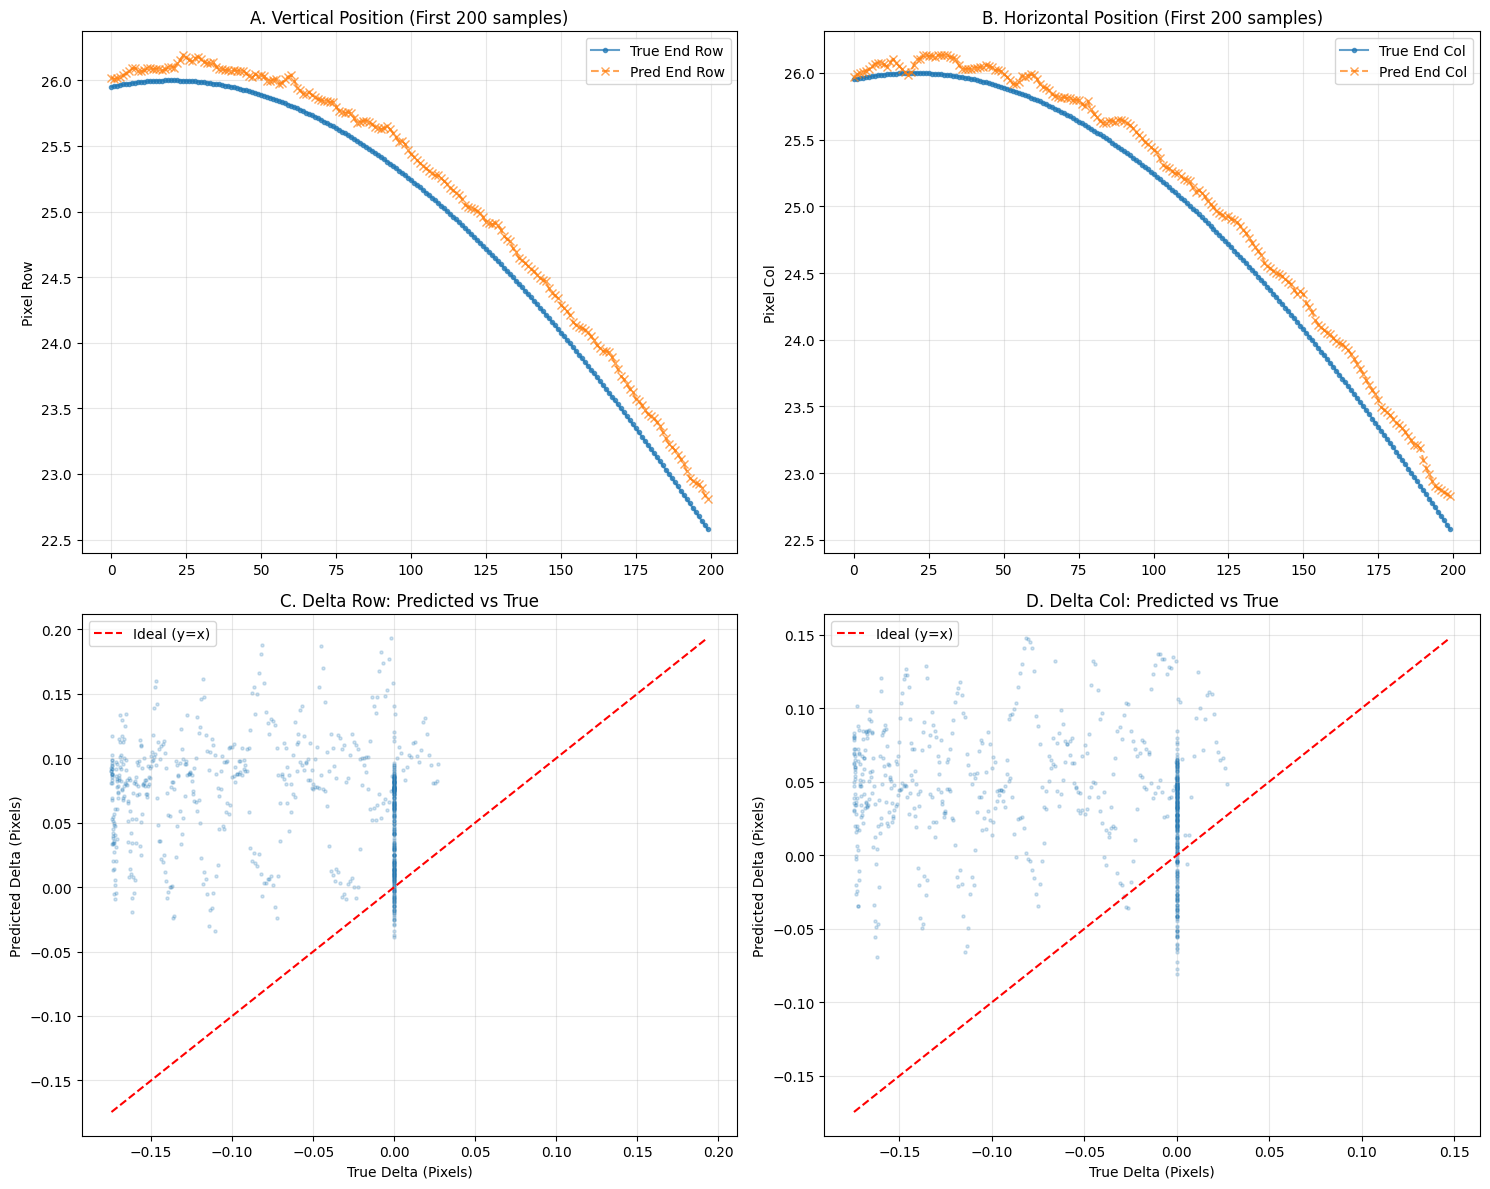

Test MSE: 0.02122
Test MAE: 0.11940


In [ ]:
# Detailed Evaluation Scheme: Absolute Positions & Error Scatter Plots

# 1. Retrieve Start Positions for the test samples to reconstruct absolute paths
# We use the indices stored in the test_ds to get the correct start rows/cols
test_indices = test_ds.indices
start_rows = hard_move.iloc[test_indices]['click_center_row'].values
start_cols = hard_move.iloc[test_indices]['click_center_col'].values

# 2. Calculate Absolute End Positions (Start + Delta)
# True End Position = Start + Ground Truth Delta
true_end_rows = start_rows + all_targets[:, 0]
true_end_cols = start_cols + all_targets[:, 1]

# Predicted End Position = Start + Predicted Delta
pred_end_rows = start_rows + all_preds[:, 0]
pred_end_cols = start_cols + all_preds[:, 1]

# 3. Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# A. Row Position Segment (Zoom in on first 200 samples)
subset = 200
axes[0, 0].plot(true_end_rows[:subset], label='True End Row', marker='.', linestyle='-', alpha=0.7)
axes[0, 0].plot(pred_end_rows[:subset], label='Pred End Row', marker='x', linestyle='--', alpha=0.7)
axes[0, 0].set_title(f'A. Vertical Position (First {subset} samples)')
axes[0, 0].set_ylabel('Pixel Row')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# B. Col Position Segment (Zoom in on first 200 samples)
axes[0, 1].plot(true_end_cols[:subset], label='True End Col', marker='.', linestyle='-', alpha=0.7)
axes[0, 1].plot(pred_end_cols[:subset], label='Pred End Col', marker='x', linestyle='--', alpha=0.7)
axes[0, 1].set_title(f'B. Horizontal Position (First {subset} samples)')
axes[0, 1].set_ylabel('Pixel Col')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# C. Scatter Plot: Predicted vs True Delta (Row)
# Ideal predictions would form a diagonal red line (y=x)
axes[1, 0].scatter(all_targets[:, 0], all_preds[:, 0], alpha=0.2, s=5)
min_val = min(all_targets[:, 0].min(), all_preds[:, 0].min())
max_val = max(all_targets[:, 0].max(), all_preds[:, 0].max())
axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal (y=x)')
axes[1, 0].set_title('C. Delta Row: Predicted vs True')
axes[1, 0].set_xlabel('True Delta (Pixels)')
axes[1, 0].set_ylabel('Predicted Delta (Pixels)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# D. Scatter Plot: Predicted vs True Delta (Col)
axes[1, 1].scatter(all_targets[:, 1], all_preds[:, 1], alpha=0.2, s=5)
min_val_c = min(all_targets[:, 1].min(), all_preds[:, 1].min())
max_val_c = max(all_targets[:, 1].max(), all_preds[:, 1].max())
axes[1, 1].plot([min_val_c, max_val_c], [min_val_c, max_val_c], 'r--', label='Ideal (y=x)')
axes[1, 1].set_title('D. Delta Col: Predicted vs True')
axes[1, 1].set_xlabel('True Delta (Pixels)')
axes[1, 1].set_ylabel('Predicted Delta (Pixels)')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Print Error Metrics
mse = np.mean((all_preds - all_targets)**2)
mae = np.mean(np.abs(all_preds - all_targets))
print(f"Test MSE: {mse:.5f}")
print(f"Test MAE: {mae:.5f}")

In [21]:
class DualInputDataset(Dataset):
    def __init__(self, data_df, gt_df, start_idx=0, end_idx=None, samples_per_epoch=1000, clip_depth=500):
        self.data = data_df.values.reshape(-1, 32, 32).astype(np.float32)
        # Add check for NaNs/Infs in the input data
        if not np.all(np.isfinite(self.data)):
            raise ValueError("Input data (hard_data_clean_70_150) contains non-finite values (NaN/Inf). Please clean your data.")

        self.gt = gt_df
        # Add check for NaNs/Infs in critical ground truth columns
        if not np.all(np.isfinite(self.gt[['click_center_row', 'click_center_col', 'vx', 'vy']].values)):
            raise ValueError("Ground truth data (hard_move) contains non-finite values (NaN/Inf) in 'click_center_row', 'click_center_col', 'vx', or 'vy'. Please clean your data.")

        self.clip_depth = clip_depth
        self.length = samples_per_epoch

        if end_idx is None:
            end_idx = len(self.data)

        self.min_idx = start_idx
        self.max_idx = end_idx - clip_depth

        if self.max_idx <= self.min_idx:
            raise ValueError(f"Invalid Index Range: {start_idx} to {end_idx}")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        # 1. Random Start
        start_t = np.random.randint(self.min_idx, self.max_idx)
        end_t = start_t + self.clip_depth

        # 2. Input A: Neural Cube (1, Depth, 32, 32)
        clip = self.data[start_t : end_t]
        x_neural = torch.tensor(clip).unsqueeze(0)

        # 3. Input B: Velocity Trace (2, Depth)
        vx = self.gt.iloc[start_t : end_t]['vx'].values
        vy = self.gt.iloc[start_t : end_t]['vy'].values
        x_velocity = np.stack([vx, vy], axis=0).astype(np.float32)
        x_velocity = torch.tensor(x_velocity)

        # Check for non-finite values in x_velocity
        if not torch.isfinite(x_velocity).all():
             raise ValueError(f"Generated x_velocity contains non-finite values at start_t={start_t}, end_t={end_t}.")

        # 4. Target: Location Delta
        row_start = self.gt.iloc[start_t]['click_center_row']
        col_start = self.gt.iloc[start_t]['click_center_col']
        row_end = self.gt.iloc[end_t]['click_center_row']
        col_end = self.gt.iloc[end_t]['click_center_col']

        # Apply round() to get integer ground truth
        delta_row = round(row_end - row_start)
        delta_col = round(col_end - col_start)
        y = torch.tensor([delta_row, delta_col], dtype=torch.float32)

        # Check for non-finite values in y
        if not torch.isfinite(y).all():
             raise ValueError(f"Generated target `y` contains non-finite values at start_t={start_t}, end_t={end_t}.")

        return x_neural, x_velocity, y

In [ ]:
class FusionNet(nn.Module):
    def __init__(self):
        super().__init__()

        # --- Branch A: Neural Processing (3D CNN) ---
        self.neural_branch = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(5, 3, 3), stride=(5, 1, 1), padding=(2, 1, 1)),
            nn.BatchNorm3d(16),
            nn.ReLU(),
            nn.MaxPool3d((2, 2, 2)),

            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.AdaptiveAvgPool3d((1, 1, 1))
        )

        # --- Branch B: Velocity Processing (1D CNN) ---
        self.velocity_branch = nn.Sequential(
            nn.Conv1d(2, 8, kernel_size=5, stride=5, padding=2),
            nn.ReLU(),
            nn.Conv1d(8, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # --- Fusion Head ---
        self.regressor = nn.Sequential(
            nn.Linear(32 + 16, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x_neural, x_velocity):
        feat_n = self.neural_branch(x_neural).view(x_neural.size(0), -1)
        feat_v = self.velocity_branch(x_velocity).view(x_velocity.size(0), -1)
        combined = torch.cat((feat_n, feat_v), dim=1)
        return self.regressor(combined)

In [ ]:
# --- Train FusionNet with Splits & Early Stopping ---

# 1. Dataset & Loader (Using train_limit / valid_limit from earlier)
train_ds_dual = DualInputDataset(hard_data_clean_70_150, hard_move, start_idx=0, end_idx=train_limit, samples_per_epoch=500)
val_ds_dual = DualInputDataset(hard_data_clean_70_150, hard_move, start_idx=train_limit, end_idx=valid_limit, samples_per_epoch=200)

train_loader_dual = DataLoader(train_ds_dual, batch_size=16, shuffle=True)
val_loader_dual = DataLoader(val_ds_dual, batch_size=16, shuffle=False)

# 2. Model
fusion_model = FusionNet().to(device)
optimizer = torch.optim.Adam(fusion_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 3. Training Loop
best_val_loss = float('inf')
patience = 5
trigger_times = 0

print("Starting FusionNet Training...")
for epoch in range(100):
    # -- TRAIN --
    fusion_model.train()
    train_loss = 0
    for x_n, x_v, y in train_loader_dual:
        x_n, x_v, y = x_n.to(device), x_v.to(device), y.to(device)
        optimizer.zero_grad()
        preds = fusion_model(x_n, x_v)
        loss = criterion(preds, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_dual)

    # -- VALIDATE --
    fusion_model.eval()
    val_loss = 0
    with torch.no_grad():
        for x_n, x_v, y in val_loader_dual:
            x_n, x_v, y = x_n.to(device), x_v.to(device), y.to(device)
            preds = fusion_model(x_n, x_v)
            val_loss += criterion(preds, y).item()

    avg_val_loss = val_loss / len(val_loader_dual)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # -- EARLY STOPPING --
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        trigger_times = 0
        torch.save(fusion_model.state_dict(), 'best_fusion_model.pth')
    else:
        trigger_times += 1
        print(f"  -> Patience: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"  -> Early Stopping! Best Val Loss: {best_val_loss:.4f}")
            fusion_model.load_state_dict(torch.load('best_fusion_model.pth'))
            break

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [22]:
class DualInputEvaluationDataset(Dataset):
    def __init__(self, data_df, gt_df, start_idx, end_idx, clip_depth=500, stride=100):
        self.data = data_df.values.reshape(-1, 32, 32).astype(np.float32)
        self.gt = gt_df
        self.clip_depth = clip_depth
        self.indices = list(range(start_idx, end_idx - clip_depth, stride))

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start_t = self.indices[idx]
        end_t = start_t + self.clip_depth

        clip = self.data[start_t : end_t]
        x_neural = torch.tensor(clip).unsqueeze(0)

        vx = self.gt.iloc[start_t : end_t]['vx'].values
        vy = self.gt.iloc[start_t : end_t]['vy'].values
        x_velocity = np.stack([vx, vy], axis=0).astype(np.float32)
        x_velocity = torch.tensor(x_velocity)

        row_start = self.gt.iloc[start_t]['click_center_row']
        col_start = self.gt.iloc[start_t]['click_center_col']
        row_end = self.gt.iloc[end_t]['click_center_row']
        col_end = self.gt.iloc[end_t]['click_center_col']

        # Apply round() to get integer ground truth
        delta_row = round(row_end - row_start)
        delta_col = round(col_end - col_start)
        y = torch.tensor([delta_row, delta_col], dtype=torch.float32)

        return x_neural, x_velocity, y

In [ ]:
fusion_model.eval()
all_preds = []
all_targets = []

print("Evaluating FusionNet on Test Data...")
with torch.no_grad():
    for x_n, x_v, y in test_loader_fusion:
        x_n, x_v = x_n.to(device), x_v.to(device)
        outputs = fusion_model(x_n, x_v)
        all_preds.append(outputs.cpu().numpy())
        all_targets.append(y.numpy())

all_preds = np.vstack(all_preds)
all_targets = np.vstack(all_targets)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
axes[0].plot(all_targets[:, 0], label='Ground Truth', alpha=0.7)
axes[0].plot(all_preds[:, 0], label='FusionNet Prediction', alpha=0.7, color='green')
axes[0].set_title('Delta Row (Vertical)')
axes[0].legend()

axes[1].plot(all_targets[:, 1], label='Ground Truth', alpha=0.7)
axes[1].plot(all_preds[:, 1], label='FusionNet Prediction', alpha=0.7, color='green')
axes[1].set_title('Delta Col (Horizontal)')
axes[1].legend()

plt.tight_layout()
plt.show()

Evaluating FusionNet on Test Data...


AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
save_path_fusion = os.path.join(save_dir, 'fusion_net_v1.pth')
torch.save(fusion_model.state_dict(), save_path_fusion)
print(f"Saved FusionNet to: {save_path_fusion}")

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
fusion_model.eval()
with torch.no_grad():
    x_n, x_v, y = val_ds_dual[0]
    pred = fusion_model(x_n.unsqueeze(0).to(device), x_v.unsqueeze(0).to(device))
    print(f"Sample Target: {y.numpy()} | Prediction: {pred[0].cpu().numpy()}")

AcceleratorError: CUDA error: device-side assert triggered
Search for `cudaErrorAssert' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
